## Summary

----

## Imports

In [1]:
import tempfile
import time
import warnings
from collections import deque
from contextlib import contextmanager
from pathlib import Path

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import seaborn as sns
import torch
import tqdm
from matplotlib.ticker import FormatStrFormatter
from scipy import stats
from tensorflow.python.summary.summary_iterator import summary_iterator
from torch_geometric.data import DataLoader

/tmp/strokach/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/tmp/strokach/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/tmp/strokach/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/tmp/strokach/env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWa

In [2]:
import proteinsolver
import proteinsolver.datasets

/tmp/strokach/env/lib/python3.7/site-packages/Bio/KDTree/__init__.py:25: BiopythonDeprecationWarning: Bio.KDTree has been deprecated, and we intend to remove it in a future release of Biopython. Please use Bio.PDB.kdtrees instead, which is functionally very similar.
  BiopythonDeprecationWarning)


In [3]:
%matplotlib inline

try:
    inline_rc
except NameError:
    inline_rc = mpl.rcParams.copy()
    
mpl.rcParams.update({"font.size": 12})

## Parameters

In [4]:
UNIQUE_ID = "191f05de"  # No attention
# UNIQUE_ID = "0007604c"  # 5-layer graph-conv with attention, batch_size=1
# UNIQUE_ID = "91fc9ab9"  # 4-layer graph-conv with attention, batch_size=4

In [5]:
BEST_STATE_FILES = {"191f05de": 53}

In [6]:
DATA_ROOT = Path(tempfile.gettempdir())
DATA_ROOT = Path("/home/strokach/ml_data")
DATA_ROOT.mkdir(exist_ok=True)
DATA_ROOT

PosixPath('/home/strokach/ml_data')

In [7]:
NOTEBOOK_NAME = "protein_analysis"
NOTEBOOK_PATH = Path(NOTEBOOK_NAME)
NOTEBOOK_PATH.mkdir(exist_ok=True)
NOTEBOOK_PATH

PosixPath('protein_analysis')

In [8]:
DATAPKG_DATA_DIR = Path(f"~/datapkg_output_dir").expanduser().resolve()
DATAPKG_DATA_DIR

PosixPath('/home/kimlab1/database_data/datapkg_output_dir')

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [10]:
proteinsolver.settings.data_url = DATAPKG_DATA_DIR.as_posix()
proteinsolver.settings.data_url

'/home/kimlab1/database_data/datapkg_output_dir'

## Load data

In [11]:
datasets = {}

In [12]:
datasets["protein_valid"] = proteinsolver.datasets.ProteinInMemoryDataset(root=DATA_ROOT / "protein_valid", subset="valid")

In [13]:
datasets["protein_test"] = proteinsolver.datasets.ProteinInMemoryDataset(root=DATA_ROOT / "protein_test", subset="test")

### Protherm

In [14]:
file = DATAPKG_DATA_DIR.joinpath("deep-protein-gen/datasets-test/protherm/protherm.parquet").as_posix()

extra_columns = ["qseq", "residue_idx_1_corrected", "residue_idx_2_corrected", "distances"]
extra_column_renames = {
    "qseq": "sequence",
    "residue_idx_1_corrected": "row_index",
    "residue_idx_2_corrected": "col_index",
}
protherm_dataset = proteinsolver.datasets.ProteinInMemoryDataset(
    root=DATA_ROOT / "protherm",
    subset="",
    data_url=file,
    extra_columns=extra_columns,
    extra_column_renames=extra_column_renames,
)
protherm_df = pq.read_table(file).to_pandas()

In [15]:
protherm_dataset[0]

Data(Index=[1], edge_attr=[7356, 2], edge_index=[2, 7356], x=[162])

In [16]:
protherm_df.head(2)

,filename_wt,chain_id,mutation,cartesian_ddg_beta_nov15_cart_1,ddg_exp,cartesian_ddg_beta_nov16_cart_1,cartesian_ddg_score12_cart_1,cartesian_ddg_talaris2013_cart_1,cartesian_ddg_talaris2014_cart_1,ddg_monomer_soft_rep_design_1,local_filename_wt,structure_id,model_id,qseq,residue_idx_1_corrected,residue_idx_2_corrected,distances,mutation_matches_sequence,qseq_mutation
0,/home/kimlab2/database_data/biological-data-wa...,A,G44S,-1.808667,-0.53,-0.701,0.088,-0.289667,-0.633667,-2.384,/home/kimlab1/database_data/datapkg/adjacency-...,107l,0,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKGEL...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 66, 70, 91...","[1.3463744749991646, 4.7287436401778065, 6.389...",True,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...
1,/home/kimlab2/database_data/biological-data-wa...,A,A120M,2.617667,-0.20,0.354,0.560,-0.069000,-0.188000,2.472,/home/kimlab1/database_data/datapkg/adjacency-...,160l,0,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 66, 70, 91, 92...","[1.345760255620924, 4.727237880524551, 6.42311...",True,MNIFEMLRIDEGLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKSEL...


## Training plots

In [17]:
!ls protein_train/runs/

0007604c.xxx  44a43c56.xxx  8a5f95bb.xxx
191f05de.xxx  4c3e6ed8.xxx  91fc9ab9.xxx


In [18]:
dfs = []

for tb_file in Path(f"protein_train/runs/{UNIQUE_ID}.xxx/").glob("*"):
    data = []
    for e in summary_iterator(tb_file.as_posix()):
        for v in e.summary.value:
            row = (e.step, v.tag, v.simple_value)
            data.append(row)
            if v.tag == "accuracy_mv":
                row = (e.step, "wall_time", e.wall_time)
                data.append(row)
    df = (
        pd.DataFrame(data, columns=["datapoint", "tag", "simple_value"])
        .pivot(index="datapoint", columns="tag", values="simple_value")
        .reset_index()
    )
    df["datapoint"] = df["datapoint"].astype(np.int)
    dfs.append(df)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


In [19]:
df = pd.concat(dfs, sort=False)
print(len(df))

28793


In [20]:
df = df.sort_values("wall_time", ascending=False).drop_duplicates(subset=["datapoint"], keep="first").sort_values("wall_time", ascending=True)
print(len(df))

27784


In [21]:
assert len(df) == len(df["datapoint"].drop_duplicates())

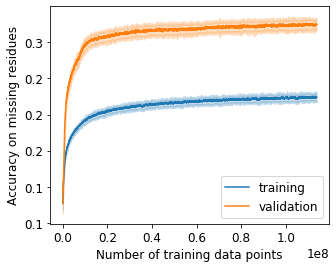

In [22]:
cmap = cm.get_cmap("tab10")

x = df["datapoint"].values
accuracy_m_mean, accuracy_m_std = df["accuracy_m"].ewm(com=16, min_periods=0).agg(['mean', 'std']).values.T
accuracy_mv_mean, accuracy_mv_std = df["accuracy_mv"].ewm(com=16, min_periods=0).agg(['mean', 'std']).values.T

# accuracy_m_std = np.nan_to_num(accuracy_m_std, 0)
# accuracy_mv_std = np.nan_to_num(accuracy_mv_std, 0)

fg, ax = plt.subplots(figsize=(5, 4))

ax.plot(x, accuracy_m_mean, label="training", color=cmap(0))
ax.fill_between(x, accuracy_m_mean - accuracy_m_std * 2, accuracy_m_mean + accuracy_m_std * 2, alpha=0.25, color=cmap(0))
ax.plot(x, accuracy_mv_mean, label="validation", color=cmap(1))
ax.fill_between(x, accuracy_mv_mean - accuracy_mv_std * 2, accuracy_mv_mean + accuracy_mv_std * 2, alpha=0.25, color=cmap(1))

# ax.hlines(0.7, 0, df["datapoint"].max(), linestyle='--')
ax.legend(loc="lower right")
ax.set_xlabel("Number of training data points")
ax.set_ylabel("Accuracy on missing residues")
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

# ax.set_ylim(0, 0.82)
fg.savefig(NOTEBOOK_PATH / f"{UNIQUE_ID}-training-curve.svg", bbox_inches="tight")

## Load model

### Find best model

In [23]:
%run protein_train/{UNIQUE_ID}/model.py

<Figure size 432x288 with 0 Axes>

In [24]:
batch_size = 1
num_features = 20
adj_input_size = 2
hidden_size = 128
frac_present = 0.5
frac_present_valid = frac_present
info_size= 1024

In [25]:
state_files = sorted(
    Path("protein_train").joinpath(UNIQUE_ID).glob("*.state"),
    key=lambda s: int(s.stem.split("-")[2].strip("d")),
)

In [26]:
if UNIQUE_ID not in BEST_STATE_FILES:
    avg_accuracies = []

    for state_file_idx, state_file in enumerate(state_files):
        net = Net(
            x_input_size=num_features + 1,
            adj_input_size=adj_input_size,
            hidden_size=hidden_size,
            output_size=num_features,
        )
        net.load_state_dict(torch.load(state_file))
        net.eval()
        net = net.to(device)

        results = []
        for i, data in enumerate(
            tqdm.tqdm_notebook(
                DataLoader(datasets["protein_valid"], shuffle=False, num_workers=1, batch_size=1, drop_last=False),
                leave=False,
                desc=f"{state_file_idx}",
            )
        ):
            data = data.to(device)
            data.y = data.x
            x_in = torch.ones_like(data.y) * 20.0
            is_missing = torch.ones(data.y.size(0), dtype=torch.bool)
            output = net(x_in, data.edge_index, data.edge_attr)
            output = torch.softmax(output, dim=1)
            _, predicted = output.max(dim=1)
            num_correct = float((predicted[is_missing] == data.y[is_missing]).sum())
            num_total = float(is_missing.sum())
            results.append(
                {"fraction_correct": num_correct / num_total, "num_correct": num_correct, "num_total": num_total}
            )

        oneshot_results_df = pd.DataFrame(results)

        datapoint = int(state_file.stem.split("-")[2].strip("d"))
        avg_accuracies.append((state_file_idx, datapoint, oneshot_results_df["fraction_correct"].mean()))
        print(avg_accuracies[-1])

In [27]:
if UNIQUE_ID not in BEST_STATE_FILES:
    _, datapoints, accuracies = np.array(avg_accuracies).T

In [28]:
if UNIQUE_ID not in BEST_STATE_FILES:
    fg, ax = plt.subplots()
    # ax.axhline(0.24, color='k', linestyle='--')
    ax.plot(datapoints, accuracies, label="valid")
    # ax.plot(valid_datapoints, valid_accuracies, label="valid")
    # ax.plot(test_datapoints, test_accuracies, label="test")
    ax.legend()
    ax.set_xlabel("Number of training data points")
    ax.set_ylabel("Average test accuracy\nwith no starting residues")

In [29]:
if UNIQUE_ID not in BEST_STATE_FILES:
    best_model_index = np.argmax(accuracies)
else:
    best_model_index = BEST_STATE_FILES[UNIQUE_ID]
best_model_index

53

### Load best model

In [30]:
state_file = state_files[best_model_index]
state_file

PosixPath('protein_train/191f05de/e53-s1952148-d93703104.state')

In [31]:
net = Net(
    x_input_size=num_features + 1, adj_input_size=adj_input_size, hidden_size=hidden_size, output_size=num_features
)
net.load_state_dict(torch.load(state_file, map_location=device))
net.eval()
net = net.to(device)

## Test set sequence identity

### Oneshot

In [33]:
results = []
for i, data in enumerate(
    tqdm.tqdm_notebook(
        DataLoader(datasets["protein_test"], shuffle=False, num_workers=1, batch_size=1, drop_last=False)
    )
):
    data = data.to(device)
    data.y = data.x
    x_in = torch.ones_like(data.y) * 20
    is_missing = torch.ones(data.y.size(0), dtype=torch.bool)
    output = net(x_in, data.edge_index, data.edge_attr)
    output = torch.softmax(output, dim=1)
    _, predicted = output.max(dim=1)
    num_correct = float((predicted[is_missing] == data.y[is_missing]).sum())
    num_total = float(is_missing.sum())
    results.append({"fraction_correct": num_correct / num_total, "num_correct": num_correct, "num_total": num_total})
oneshot_results_df = pd.DataFrame(results)

/tmp/strokach/env/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [34]:
fraction_correct_oneshot = (oneshot_results_df["num_correct"] / oneshot_results_df["num_total"]).mean()
fraction_correct_oneshot

0.26572328322385497

### Incremental

In [35]:
@torch.no_grad()
def design_protein(net, x, edge_index, edge_attr):
    mask = (x == 20)
    if not mask.any():
        return x
    output = net(x, edge_index, edge_attr)
    output = torch.softmax(output, dim=1)
    max_pred, max_index = output.max(dim=1)
    max_pred[~mask] = -1
    _, max_residue = max_pred.max(dim=0)
    x[max_residue] = max_index[max_residue]
    return design_protein(net, x, edge_index, edge_attr)

In [36]:
test_sequence_identity = {}

In [37]:
for frac_present in [0.0, 0.5, 0.8]:
    results = []
    for i, data in enumerate(
        tqdm.tqdm_notebook(
            DataLoader(datasets["protein_test"], shuffle=False, num_workers=1, batch_size=1, drop_last=False)
        )
    ):
        data.to(device)
        if frac_present == 0:
            is_present = torch.zeros(data.x.size(0), dtype=torch.bool, device=data.x.device)
            x_in = torch.ones_like(data.x) * 20
        else:
            is_present = torch.rand(data.x.size(0), device=data.x.device) < frac_present
            x_in = torch.where(is_present, data.x, torch.tensor(20, device=data.x.device))
        x_pred = design_protein(net, x_in, data.edge_index, data.edge_attr)
        identity_all = float((x_pred == data.x).sum()) / data.x.size(0)
        identity_missing = float((x_pred[~is_present] == data.x[~is_present]).sum()) / (~is_present).sum().item()
        result = {
            "identity_all": identity_all,
            "identity_missing": identity_missing,
            "num_correct": (x_pred[~is_present] == data.x[~is_present]).sum().item(),
            "num_total": (~is_present).sum().item(),
        }
        results.append(result)
    test_sequence_identity[frac_present] = pd.DataFrame(results)

/tmp/strokach/env/lib/python3.7/site-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


In [38]:
fraction_correct_incremental = (test_sequence_identity[0.0]["num_correct"] / test_sequence_identity[0.0]["num_total"]).mean()
fraction_correct_incremental

0.2597274480486342

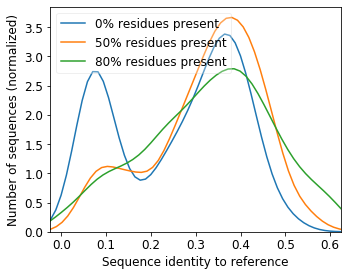

In [39]:
xlim = -0.025, 0.625

fg, ax = plt.subplots(figsize=(5, 4))
for frac, df in sorted(test_sequence_identity.items()):
    data = df["identity_missing"]
    data = np.clip(data, *xlim)
#         ax.hist(data, bins=30, range=xlim, histtype="step", label=f"{frac:.0%} missing residues", linewidth=1.5)
    sns.kdeplot(data, gridsize=35, label=f"{frac:.0%} residues present")
ax.set_ylabel("Number of sequences (normalized)")
ax.set_xlabel("Sequence identity to reference")
ax.set_xlim(*xlim)
# ax.set_ylim(0, 4.2)
ax.legend(loc="upper left", framealpha=0.3)
fg.tight_layout()
fg.savefig(NOTEBOOK_PATH.joinpath(f"{UNIQUE_ID}-test-incremental-kde.svg"), bbox_inches="tight")

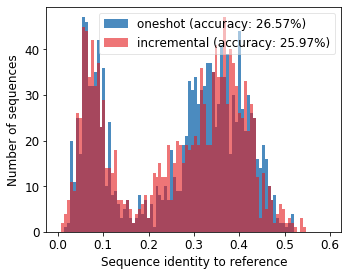

In [40]:
fg, ax = plt.subplots(figsize=(5, 4))

xlim = -0.025, 0.625

data = oneshot_results_df["fraction_correct"]
data = np.clip(data, *xlim)
ax.hist(
    data,
    bins=100,
    range=xlim,
    alpha=0.9,
    label=f"oneshot (accuracy: {fraction_correct_oneshot:.2%})",
    histtype="stepfilled",
    linewidth=2,
    color=cm.get_cmap("Set1")(1),
)
# sns.kdeplot(data, gridsize=200, label="oneshot")

data = test_sequence_identity[0.0]["identity_missing"]
data = np.clip(data, *xlim)
ax.hist(
    data,
    bins=100,
    range=xlim,
    alpha=0.6,
    label=f"incremental (accuracy: {fraction_correct_incremental:.2%})",
    histtype="stepfilled",
    linewidth=2,
    color=cm.get_cmap("Set1")(0),
)
# sns.kdeplot(data, gridsize=100, label="incremental")

ax.set_ylabel("Number of sequences")
ax.set_xlabel("Sequence identity to reference")
ax.set_xlim(xlim)
# ax.set_ylim(0, 165)

ax.legend(framealpha=0.5)

fg.tight_layout()
fg.savefig(NOTEBOOK_PATH.joinpath(f"{UNIQUE_ID}-test-oneshot-incremental.svg"), bbox_inches="tight")

## Protherm validation

In [41]:
results = []

for i, data in enumerate(tqdm.tqdm_notebook(protherm_dataset, total=len(protherm_dataset))):
    data = data.to(device)

    row = protherm_df.loc[data.Index.item()]
    with torch.no_grad():
        output = net(data.x, data.edge_index, data.edge_attr)
    output_sm = torch.softmax(output, dim=1)

    wt_idx = torch.tensor(proteinsolver.utils.seq_to_tensor(row.mutation[0].encode()), dtype=torch.long, device=device)
    mut_idx = torch.tensor(
        proteinsolver.utils.seq_to_tensor(row.mutation[-1].encode()), dtype=torch.long, device=device
    )
    pos = int(row.mutation[1:-1])
    x_mut = data.x.clone()
    assert x_mut[pos - 1] == wt_idx
    x_mut[pos - 1] = mut_idx
    with torch.no_grad():
        output_mut = net(x_mut, data.edge_index, data.edge_attr)
    output_mut_sm = torch.softmax(output_mut, dim=1)

    x_blank = data.x.clone()
    assert x_blank[pos - 1] == wt_idx
    x_blank[pos - 1] = 20
    with torch.no_grad():
        output_blank = net(x_blank, data.edge_index, data.edge_attr)
    output_blank_sm = torch.softmax(output_blank, dim=1)

    result = {
        "wt_wt": output[pos - 1, wt_idx].item(),
        "wt_mut": output[pos - 1, mut_idx].item(),
        "wt_sm_wt": output_sm[pos - 1, wt_idx].item(),
        "wt_sm_mut": output_sm[pos - 1, mut_idx].item(),
        "mut_wt": output_mut[pos - 1, wt_idx].item(),
        "mut_mut": output_mut[pos - 1, mut_idx].item(),
        "mut_sm_wt": output_mut_sm[pos - 1, wt_idx].item(),
        "mut_sm_mut": output_mut_sm[pos - 1, mut_idx].item(),
        "blank_wt": output_blank[pos - 1, wt_idx].item(),
        "blank_mut": output_blank[pos - 1, mut_idx].item(),
        "blank_sm_wt": output_blank_sm[pos - 1, wt_idx].item(),
        "blank_sm_mut": output_blank_sm[pos - 1, mut_idx].item(),
        "ddg_exp": row.ddg_exp,
    }
    results.append(result)

results_df = pd.DataFrame(results)

/tmp/strokach/env/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [42]:
results_df["blank_change"] = results_df["blank_mut"] - results_df["blank_wt"]
results_df["blank_sm_change"] = results_df["blank_sm_mut"] - results_df["blank_sm_wt"]

results_df["wt_mut_change"] = results_df["mut_mut"] - results_df["wt_wt"]
results_df["wt_mut_sm_change"] = results_df["mut_sm_mut"] - results_df["wt_sm_wt"]

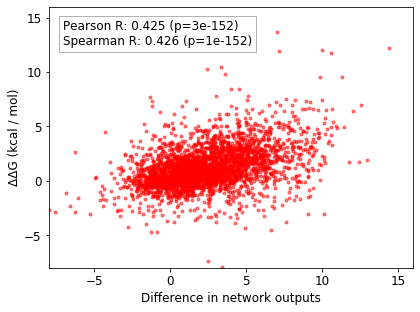

In [43]:
column = "blank_change"
ddg_change = results_df[column].values
ddg_exp = results_df["ddg_exp"].values
textstr = """\
Pearson R: {:.3f} (p={:.0e})
Spearman R: {:.3f} (p={:.0e})
""".format(
    *stats.pearsonr(-ddg_change, ddg_exp), *stats.spearmanr(-ddg_change, ddg_exp)
).strip()
props = dict(facecolor="white", alpha=0.3)

with plt.rc_context(rc={"font.size": 12}):
    fg, ax = plt.subplots(figsize=(6, 4.5))
    ax.plot(-ddg_change, ddg_exp, "r.", alpha=0.5)
    ax.set_xlabel("Difference in network outputs")
    ax.set_ylabel("ΔΔG (kcal / mol)")
    ax.set_xlim(-8, 16)
    ax.set_ylim(-8, 16)
    ax.text(0.04, 0.95, textstr, transform=ax.transAxes, fontsize="medium", verticalalignment="top", bbox=props)
fg.tight_layout()
fg.savefig(NOTEBOOK_PATH.joinpath(f"{UNIQUE_ID}-protherm-all.svg"), bbox_inches="tight")

## Perplexities

In [44]:
def calculate_perplexity(net, x, edge_index, edge_attr, x_in=None):
    if x_in is None:
        x_in = torch.ones_like(x) * 20

    mask = x_in == 20

    if not mask.any().item():
        return []

    output = net(x_in, edge_index, edge_attr)
    output = torch.softmax(output, dim=1)

    probas = output.gather(1, x.view(-1, 1))
    probas[~mask] = -1

    max_proba, max_residue = probas.max(dim=0)
    x_in[max_residue] = x[max_residue]

    return [max_proba.item()] + calculate_perplexity(net, x, edge_index, edge_attr, x_in=x_in)

In [45]:
proba_lists = []
for i, data in enumerate(
    tqdm.tqdm_notebook(
        DataLoader(datasets["protein_test"], shuffle=False, num_workers=1, batch_size=1, drop_last=False)
    )
):
    data = data.to(device)
    with torch.no_grad():
        proba_lst = calculate_perplexity(net, data.x, data.edge_index, data.edge_attr)
    assert len(proba_lst) == data.x.size(0)
    proba_lists.append(proba_lst)

/tmp/strokach/env/lib/python3.7/site-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


In [46]:
perplexities = [2 ** -(np.log2(proba_lst).mean()) for proba_lst in proba_lists]
print(np.mean(perplexities))

9.330723680973703


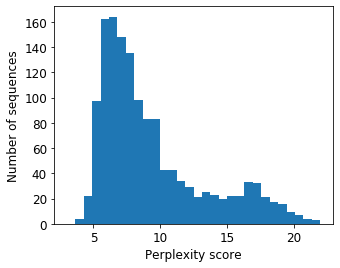

In [47]:
fg, ax = plt.subplots(figsize=(5, 4))
ax.hist(np.clip(perplexities, 3, 22), bins=30, range=(3, 22))
ax.set_xlabel("Perplexity score")
ax.set_ylabel("Number of sequences")
fg.savefig(NOTEBOOK_PATH.joinpath(f"{UNIQUE_ID}-perplexity.svg"), bbox_inches="tight")

In [48]:
raise Exception("Done!")

Exception: Done!

In [ ]:
results = []

for i, data in enumerate(tqdm.tqdm_notebook(protherm_dataset, total=len(protherm_dataset))):
    row = protherm_df.loc[data.Index.item()]
    data = data.to(device)

    with torch.no_grad():
        log_prob_wt = proteinsolver.utils.get_node_proba(net, data.x, data.edge_index, data.edge_attr, 20)

    wt_idx = torch.tensor(proteinsolver.utils.seq_to_tensor(row.mutation[0].encode()), dtype=torch.long, device=device)
    mut_idx = torch.tensor(proteinsolver.utils.seq_to_tensor(row.mutation[-1].encode()), dtype=torch.long, device=device)
    pos = int(row.mutation[1:-1])
    x_mut = data.x.clone()
    assert x_mut[pos - 1] == wt_idx
    x_mut[pos - 1] = mut_idx
    with torch.no_grad():
        log_prob_mut = proteinsolver.utils.get_node_proba(net, x_mut, data.edge_index, data.edge_attr, 20)
        
    results.append(log_prob_mut.sum().item() - log_prob_wt.sum().item())
        
results_df["sum_log_prob_change"] = results

In [ ]:
column = "sum_log_prob_change"
ddg_change = results_df[column].values
ddg_exp = results_df["ddg_exp"].values
textstr = """\
Pearson R: {:.3f} (p={:.0e})
Spearman R: {:.3f} (p={:.0e})
""".format(
    *stats.pearsonr(-ddg_change, ddg_exp), *stats.spearmanr(-ddg_change, ddg_exp)
).strip()
props = dict(facecolor="white", alpha=0.3)

with plt.rc_context(rc={"font.size": 12}):
    fg, ax = plt.subplots(figsize=(6, 4.5))
    ax.plot(-ddg_change, ddg_exp, "r.", alpha=0.5)
    ax.set_xlabel("Difference in network outputs")
    ax.set_ylabel("ΔΔG (kcal / mol)")
    ax.set_xlim(-8, 16)
    ax.set_ylim(-8, 16)
    ax.text(0.04, 0.95, textstr, transform=ax.transAxes, fontsize="medium", verticalalignment="top", bbox=props)
fg.tight_layout()
# fg.savefig(NOTEBOOK_PATH.joinpath("protherm-all.svg"))

In [ ]:
# table = pa.Table.from_pandas(results_df)
# pq.write_table(table, NOTEBOOK_PATH.joinpath("results.parquet"))